In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("mirrorPublications_featured_final.csv")

#codifico topics in one-hot encoding
one_hot_encoded_topics = pd.get_dummies(df['topic'], prefix='topic')
#trasformo i valori True e False in 0 e 1
one_hot_encoded_topics = one_hot_encoded_topics.astype(int)
#concatenazione i risultati con il df originale
df = pd.concat([df, one_hot_encoded_topics], axis=1)

df.loc[:, 'Price(ETH)'] = df['Price(ETH)'].replace(0, 0.0001)
df.loc[:, 'Success'] = (df['Total Sold Numbers'] * df['Price(ETH)']) / (df['Total Buyers'] + 1)

threshold = df['Success'].median()  # Soglia basata sulla mediana

# Creazione della colonna SuccessBinary
df['SuccessBinary'] = np.where(df['Success'] >= threshold, 1, 0)

counts = df['SuccessBinary'].value_counts()
counts

SuccessBinary
1    13710
0    13169
Name: count, dtype: int64

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Esempio: Preprocessing dei dati
# Separa il tuo dataframe in variabili di input (X) e target (y)
X = df.drop(columns=['Writing NFT', 'Author Homepage', 'Total Sold(ETH)', 'Total Sold Numbers', 'Total Buyers',
    'Price(ETH)', 'nft_address', 'collection', 'fees', 'created_date', 'link', 'digest', 'body', 'timestamp', 'title', 'cleaned_text', 
    'cleaned_body', 'cleaned_title', 'processed_cleaned_text', 'weekday', 'language',
    'cleaned_text_tokenized', 'cleaned_text_lemmatized', 'cleaned_text_POS', "topic",
    'transaction_id', 'Success', 'SuccessBinary'])
y = df['SuccessBinary']

# Suddividi in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Applica imputazione per i valori NaN
imputer = SimpleImputer(strategy='mean')  # Puoi cambiare la strategia (media, mediana, costante, ecc.)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardizza i dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

Epoch 1/100
538/538 [==============================] - 1s 707us/step - loss: 0.7445 - accuracy: 0.5856 - val_loss: 0.7160 - val_accuracy: 0.6180
Epoch 2/100
538/538 [==============================] - 0s 610us/step - loss: 0.7168 - accuracy: 0.6217 - val_loss: 0.7060 - val_accuracy: 0.6301
Epoch 3/100
538/538 [==============================] - 0s 611us/step - loss: 0.7124 - accuracy: 0.6222 - val_loss: 0.6997 - val_accuracy: 0.6359
Epoch 4/100
538/538 [==============================] - 0s 611us/step - loss: 0.7015 - accuracy: 0.6360 - val_loss: 0.6954 - val_accuracy: 0.6394
Epoch 5/100
538/538 [==============================] - 0s 605us/step - loss: 0.6943 - accuracy: 0.6413 - val_loss: 0.6917 - val_accuracy: 0.6403
Epoch 6/100
538/538 [==============================] - 0s 603us/step - loss: 0.6919 - accuracy: 0.6427 - val_loss: 0.6885 - val_accuracy: 0.6412
Epoch 7/100
538/538 [==============================] - 0s 608us/step - loss: 0.6869 - accuracy: 0.6474 - val_loss: 0.6863 - val_ac

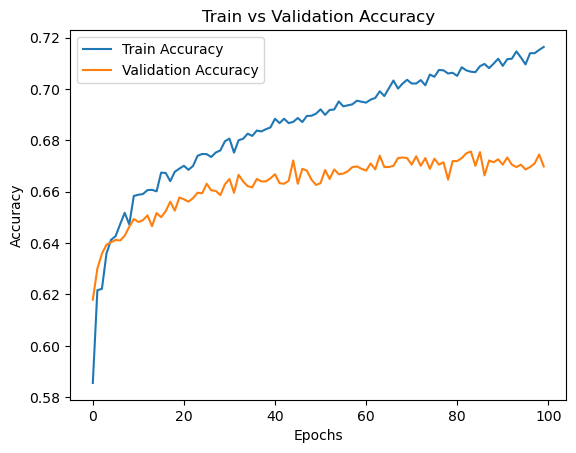

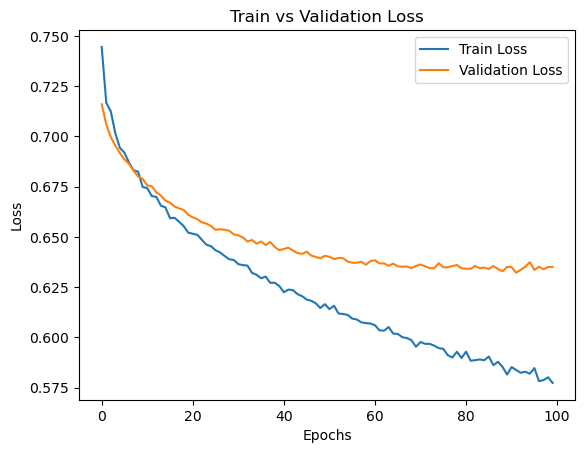

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def build_and_train_best_model(X_train_scaled, y_train, X_test_scaled, y_test):
    # Parametri ottimizzati
    units_layer1 = 224
    units_layer2 = 160
    dropout_rate1 = 0.1
    dropout_rate2 = 0.5
    l2_rate = 0.0002708552306012994
    learning_rate = 0.0001

    # Costruzione del modello
    model = Sequential()
    model.add(Dense(
        units=units_layer1,
        activation='relu',
        input_dim=X_train_scaled.shape[1],
        kernel_regularizer=l2(l2_rate)  # Regolarizzazione L2
    ))
    model.add(Dropout(dropout_rate1))  # Dropout dopo il primo livello

    model.add(Dense(
        units=units_layer2,
        activation='relu',
        kernel_regularizer=l2(l2_rate)  # Regolarizzazione L2
    ))
    model.add(Dropout(dropout_rate2))  # Dropout dopo il secondo livello

    model.add(Dense(1, activation='sigmoid'))  # Livello di output

    # Compilazione del modello
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Early Stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Addestramento del modello
    history = model.fit(
        X_train_scaled, y_train,
        epochs=100,
        validation_split=0.2,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping]
    )

    # Valutazione sul test set
    y_pred_proba = model.predict(X_test_scaled)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Stampa il classification report
    from sklearn.metrics import classification_report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Visualizzazione della cronologia dell'addestramento
    import matplotlib.pyplot as plt

    # Accuratezza
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Train vs Validation Accuracy')
    plt.show()

    # Perdita
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Validation Loss')
    plt.show()

    # Restituisce il modello addestrato
    return model

# Esegui la funzione
model = build_and_train_best_model(X_train_scaled, y_train, X_test_scaled, y_test)

<h1>Explainability locale su 4 esempi non casuali:
    
- 1 caso della classe positiva lontano al decision boundary
  
- 1 caso della classe positiva vicino al decision boundary
  
- 1 caso della classe negativa lontano al decision boundary
  
- 1 caso della classe negativa vicino al decision boundary</h1>

157/157 [==============================] - 0s 1ms/step

Caso: Classe Positiva lontano, Index 1755


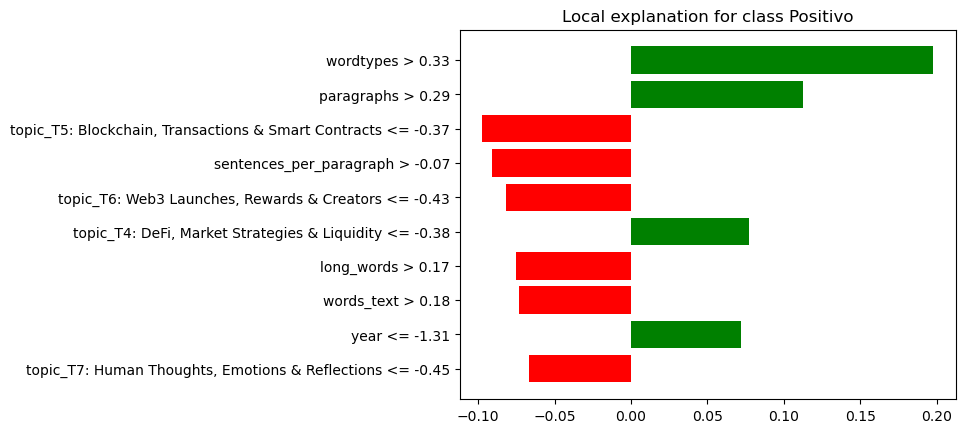

157/157 [==============================] - 0s 669us/step

Caso: Classe Positiva vicino, Index 4508


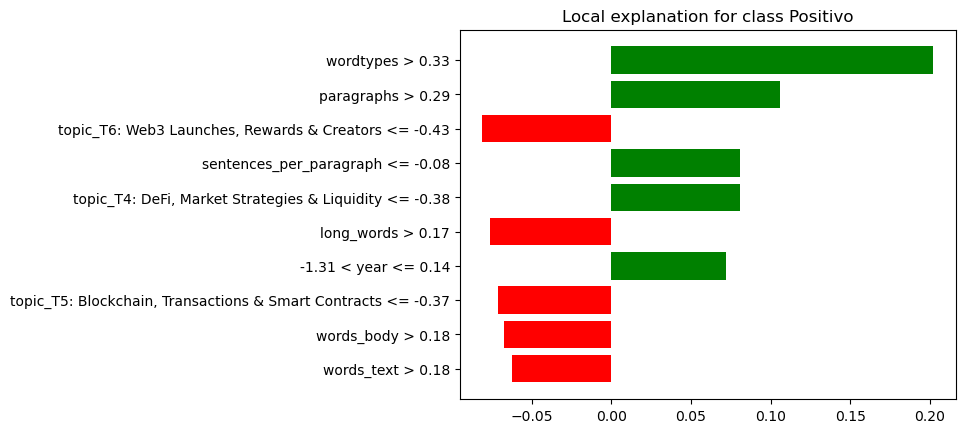

157/157 [==============================] - 0s 1ms/step

Caso: Classe Negativa lontano, Index 2542


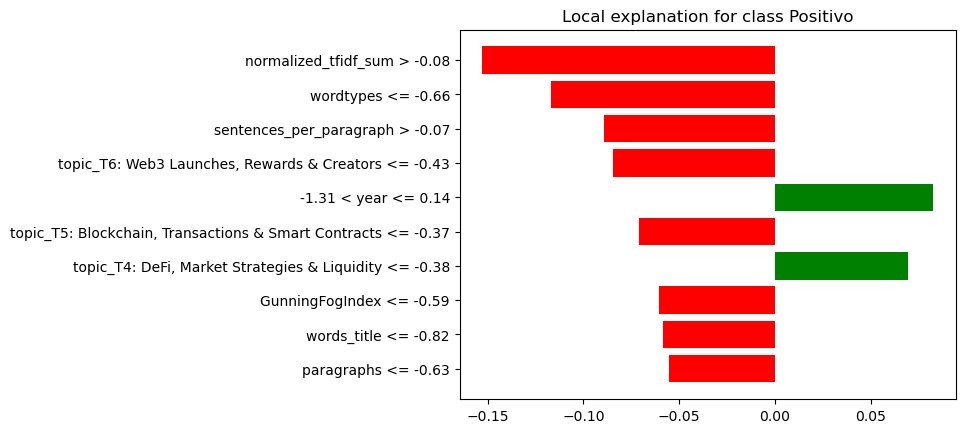

157/157 [==============================] - 0s 1ms/step

Caso: Classe Negativa vicino, Index 4780


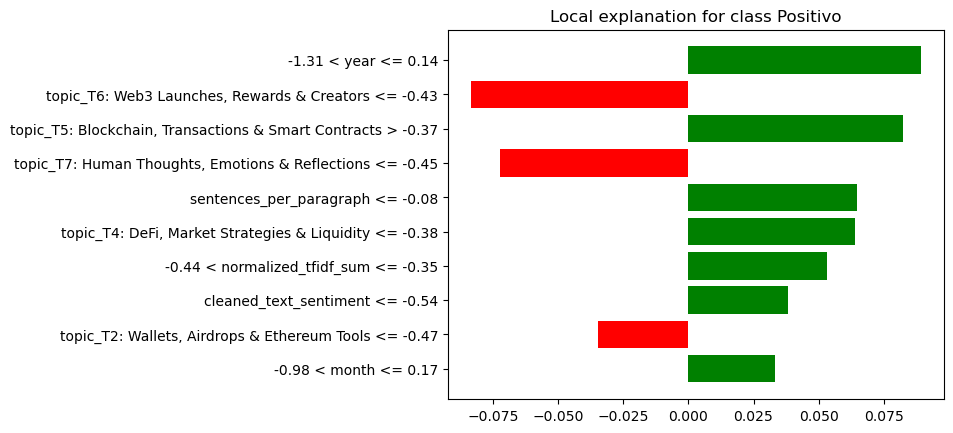

In [13]:
import numpy as np
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def predict_proba(X):
    prob = model.predict(X)
    return np.hstack([1 - prob, prob])

# Ottieni le probabilità di previsione per il test set
y_pred_proba = model.predict(X_test_scaled).flatten()

# Trova i casi specifici
class_positiva = np.where(y_test == 1)[0]
class_negativa = np.where(y_test == 0)[0]

# Individua il caso lontano dal decision boundary (probabilità molto alta o molto bassa)
pos_lontano = class_positiva[np.argmax(y_pred_proba[class_positiva])]
neg_lontano = class_negativa[np.argmin(y_pred_proba[class_negativa])]

# Individua il caso vicino al decision boundary (probabilità più vicina a 0.5)
pos_vicino = class_positiva[np.argmin(np.abs(y_pred_proba[class_positiva] - 0.5))]
neg_vicino = class_negativa[np.argmin(np.abs(y_pred_proba[class_negativa] - 0.5))]

# Inizializza LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    mode='classification',
    feature_names=X.columns.tolist(),
    class_names=['Negativo', 'Positivo'],
    discretize_continuous=True
)

def explain_instance(instance_index, label):
    exp = explainer.explain_instance(
        X_test_scaled[instance_index], 
        predict_proba,
        num_features=10
    )
    print(f"\nCaso: Classe {label}, Index {instance_index}")
    exp.show_in_notebook()
    exp.as_pyplot_figure()
    plt.show()

# Spiegazione dei quattro casi
explain_instance(pos_lontano, "Positiva lontano")
explain_instance(pos_vicino, "Positiva vicino")
explain_instance(neg_lontano, "Negativa lontano")
explain_instance(neg_vicino, "Negativa vicino")